In [1]:
magma_dir = '/home/marco/epfl/magma/'
cache_dir = None

#### AWS

In [2]:
magma_dir = '/home/ubuntu/magma/'
bucket_dir = '/home/ubuntu/s3/'
transformers_dir = '/home/ubuntu/transformers/'
cache_dir = bucket_dir+'.cache/'

### **Config**

In [3]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
MODEL = 't5'
MODELS = {}

In [5]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para_rouge/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/assign_bullets_para_rouge/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

#### AWS

In [6]:
data_dir = bucket_dir + 'datasets/karger_books_para_rouge/'+MODEL+'/'

### **Init**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [8]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache_dir)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path, cache_dir=cache_dir)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache_dir)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path, cache_dir=cache_dir)
    elif 't5' in MODEL:
        from transformers import T5ForConditionalGeneration, T5Tokenizer

        model = T5ForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache_dir)
        tokenizer = T5Tokenizer.from_pretrained(model_name_or_path, cache_dir=cache_dir)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [9]:
def print_examples(model_name_list, df, n_examples=10):
    
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
        for model_name in model_name_list:
            model, tokenizer = import_model_tok(model_name)
            model = model.to(device)
            
            summ_enc = model.generate(
                tokenizer.encode('summarize: '+row.text,
                    return_tensors='pt', truncation=True).to(device),
                min_length = config.ONE_BULLET_MIN_LEN,
                max_length = config.ONE_BULLET_MAX_LEN,
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]
            summ_num_tok = len(summ_enc)
            summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

            print('Prediction\n%s (%d tok):\n'%(model_name, summ_num_tok))
            print(fill(summ, 100))
            print()
            
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        print(''.join(['#']*100))
        print()

##### Plot Evaluation

In [10]:
def plot_evaluation_bullet_by_bullet(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_bullet_by_bullet.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+3))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-2]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
        
    box_plt_list.append(
        plt.boxplot(
        df['st_cosine_sim'].tolist(),
        positions=[xticks[-2]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['w2v_cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-2]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES+['ST Cosine', 'W2V Cosine'], fontsize='x-large')
    plt.show()

In [11]:
def plot_evaluation_grouping_bullets(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_grouped.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+3))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-2]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['st_cosine_sim'].tolist(),
        positions=[xticks[-2]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['w2v_cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-2]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES+['ST Cosine', 'W2V Cosine'], fontsize='x-large')
    plt.show()

## **Karger Books Para**

In [12]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [13]:
print_examples([
    't5-large'],
    df_train)

(9781912776696, 'hh-5')
Kaplan-Meier survival curves are often used to compare the data between two groups of subjects.
Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patients with human epidermal
growth factor receptor 2 (HER2)-positive metastatic breast cancer treated either with or without
trastuzumab. The Kaplan-Meier curve steps down at time points at which deaths occur, while censored
observations are denoted by notches on the curve. In this study, the follow-up period ranged from 3
months to 74 months. The Kaplan-Meier curve plots the probability of being event free over time,
with these probabilities being estimated from the data in the study. Note that the curve for
patients who received trastuzumab is consistently above the curve for those who did not receive
trastuzumab, indicating a higher survival probability in that group.



Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Prediction
t5-large (60 tok):

the Kaplan-Meier curve steps down at time points at which deaths occur. in this study, the follow-up
period ranged from 3 months to 74 months. the curve for patients who received trastuzumab is
consistently above the curve.

Reference:
Kaplan-Meier curves plot the probability of being event free over time. The curves from different
treatment groups can be plotted against each other to show the differences in outcome.

####################################################################################################

(9781908541062, 'ch_9')
The acute and chronic consequences of rheumatoid arthritis (RA) result from persistent, misdirected
and inadequately controlled inflammation that causes tissue destruction and loss of function.
Consequently, management strategies for RA have become highly refined over the past 10 years. The
concept of long-term therapy with non-steroidal anti-inflammatory drugs (NSAIDs) or corticosteroids
while awaiting a natural remi

Prediction
t5-large (53 tok):

bone pain or pathological fractures may result from skeletal metastases. anemia and hypercalcemia
may occur as metabolic complications of advanced disease. headache or disordered thought processes
are uncommon as a presenting feature.

Reference:
Recurrent infections may indicate an underlying tumor.

####################################################################################################

(9781910797310, 'chp2')
About 70% of patients present with advanced stage lung cancer. Diagnosis is usually made from small
biopsy and cytology specimens. Historically, pathologists only needed to distinguish between small-
cell lung cancer (SCLC) and non-small-cell lung cancer (NSCLC), but in recent years therapeutic and
genetic advances have driven the need for larger quantities of tissue for histological
subclassification, immunohistochemistry and molecular and immune pathology. The 2015 World Health
Organization Classification of Tumors of the Lung, Pleu

##### Print Val Examples

In [ ]:
print_examples([
    't5-large'],
    df_val)

##### Print Test Examples

In [ ]:
print_examples([
    't5-large'],
    df_test)

##### Summarize Test

In [13]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    
    text_list = ['summarize: '+t for t in df.text.tolist()]

    input_ids = tokenizer(text_list, return_tensors='pt', truncation=True, padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary'] = summs
    
    df.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [14]:
df_test = summarize('t5-large', df_test, 8)

100%|██████████| 31/31 [05:48<00:00, 11.23s/it]


### **Evaluation**

In [13]:
from datasets import load_metric

metric = load_metric("rouge")

from sentence_transformers import SentenceTransformer

sentence_distilroberta = SentenceTransformer('paraphrase-distilroberta-base-v1')

import gensim

#### Evaluate summaries bullet by bullet

In [14]:
def evaluate_model_bullet_by_bullet(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
    
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_bullet_by_bullet.csv')
    
    return df_eval

In [15]:
evaluate_model_bullet_by_bullet('t5-large')

bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Depression is complex, and understanding and h...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   
              ch_4     Lipid disorders and hypertension are exacerbat...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Universal versus selected prevention approache...   
              chp6     Overall, findings from trials conducted in a r...   
              chp6     The attention given to improving recognition o...   
              chp6     Psychological approaches using the computer an...   
              chp6     Regimen changes. Increasing the dose may be be...   
...                                                                  ...   
9781908541680 ch_4     Definition of the metabolic syndrome is of val...   
              ch_4     Definition of the metabolic syndrome is of val...   
              ch_4     Is weight loss always beneficial? Obesity, par...   
              ch_4     Individuals of South Asian origin are more at ...   
              ch_4     Mechanism of obesity-related hypertension. Inc...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                                                 summary  \
book          chapter                                                      
9781910797631 chp6     universally directed services are a vital part...   
              chp6     preventive interventions may reduce the incide...   
              chp6     depression covers a spectrum of symptoms, and ...   
              chp6     internet-based CBT programs, such as MoodGym a...   
              chp6     increasing the dose may be beneficial, but the...   
...                                                                  ...   
9781908541680 ch_4     metabolic syndrome is defined as a group of ca...   
              ch_4     metabolic syndrome is defined as a group of ca...   
              ch_4     obesity, particularly when severe, is associat...   
              ch_4     individuals of south Asian origin are more at ...   
              ch_4     renin-angiotensin-aldosterone system causally ...   

                       rouge1_precision  rouge1_recall  rouge1_fmeasure  \
book          chapter                                                     
9781910797631 chp6            29.268293      28.571429        28.915663   
              chp6            19.565217      18.750000        19.148936   
              chp6            26.829268      34.375000        30.136986   
              chp6            22.500000      36.000000        27.692308   
              chp6             8.108108      12.000000         9.677419   
...                                 ...            ...              ...   
9781908541680 ch_4           

#### Evaluate summaries grouping bullets

In [16]:
def evaluate_model_grouping_bullets(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    df_eval = df_eval.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary': lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
            
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
    df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_grouped.csv')
    
    return df_eval

In [17]:
evaluate_model_grouping_bullets('t5-large')

,,text,bullets,summary,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure,st_cosine_sim,w2v_cosine_sim
book,chapter,,,,,,,,,,,,,,
9781910797631,chp6,Universal versus selected prevention approache...,The treatment rather than the prevention of de...,universally directed services are a vital part...,34.146341,40.697674,37.135279,4.411765,5.263158,4.800000,14.146341,16.860465,15.384615,74.863487,86.917639
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,gallstones are a significant cause of morbidit...,40.109890,57.031250,47.096774,15.469613,22.047244,18.181818,24.175824,34.375000,28.387097,82.646734,87.508303
9781908541277,ch_12,Depression is the most prevalent psychiatric c...,Depression and anxiety are common in patients ...,depression is the most prevalent psychiatric c...,28.571429,51.006711,36.626506,12.075472,21.621622,15.496368,17.669173,31.543624,22.650602,69.391733,89.331806
9781910797907,chp6,Red blood cell (RBC) transfusions are frequent...,The decision for transfusion therapy relates t...,transfusions are frequently used to support pa...,44.117647,57.251908,49.833887,18.934911,24.615385,21.404682,26.470588,34.351145,29.900332,87.971002,90.407383
9781908541277,ch_8,Dosage. CBZ should be introduced at low doses ...,This wider choice of AEDs permits pharmacologi...,CBZ should be introduced at low doses (100-200...,15.942029,42.307692,23.157895,2.919708,7.843137,4.255319,11.594203,30.769231,16.842105,63.795978,64.427656
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,acute exacerbations of chronic obstructive pul...,19.921875,57.303371,29.565217,8.235294,23.863636,12.244898,12.890625,37.078652,19.130435,71.152931,79.887873
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,MRI studies demonstrated for the first time th...,24.675325,55.339806,34.131737,8.695652,19.607843,12.048193,13.852814,31.067961,19.161677,73.710769,90.974820
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,CGP offers a complete evaluation of the genomi...,40.625000,53.278689,46.099291,18.867925,24.793388,21.428571,28.125000,36.885246,31.914894,77.460581,85.128105
9781910797105,ch04,The most straightforward studies in population...,Having a close relative with schizophrenia inc...,schizophrenia rates are assessed in the biolog...,18.128655,43.661972,25.619835,4.705882,11.428571,6.666667,11.695906,28.169014,16.528926,71.059000,76.251704


#### Plot evaluation bullet by bullet

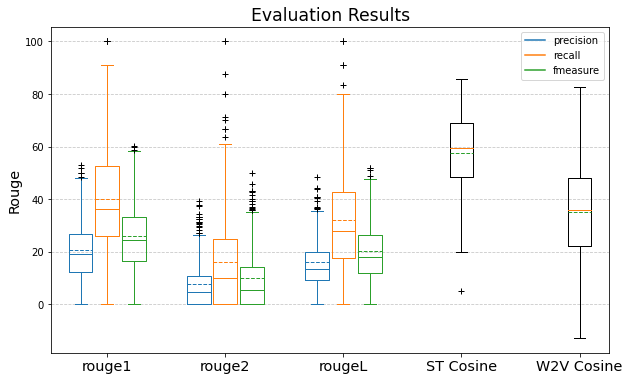

In [18]:
plot_evaluation_bullet_by_bullet('t5-large')

#### Plot evaluation grouping bullets

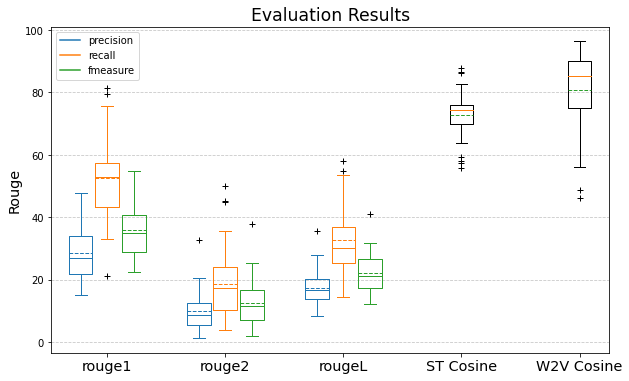

In [19]:
plot_evaluation_grouping_bullets('t5-large')